# siamese networks for whale classification

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
from skimage import io, transform
import skimage
import glob
from tqdm import tnrange, tqdm
from collections import Counter
from random import shuffle
from sklearn.preprocessing import OneHotEncoder
from IPython.display import clear_output

%matplotlib inline

In [3]:
# some prep steps
data_folder = "data/"

In [4]:
#load .npz-file from folder



loader = np.load(data_folder+"humpback_300x100_gray_no_new.npz")
features = loader["features"]
labels = loader["labels"]

n_rows = labels.shape[0]



train_ratio = 0.8
data_size = 2000

#take the sample from the most common classes
ar = np.array(Counter(labels).most_common())
count = 0
label_list = []
for idx, tup in enumerate(ar):
    label_list.append(tup[0])
    count += tup[1]
    if count > data_size:
        break
label_list

label_in_list=[x in label_list for x in labels]
labels = labels[label_in_list]
features = features[label_in_list]






In [5]:
features_a = []
labels_a = []
features_b = []
labels_b = []

for i in tqdm(range(2*data_size)):
    idx_a = np.random.randint(0, labels.shape[0])
    label_a = labels[idx_a]
    feature_a = features[idx_a]
    should_get_same_class = np.random.randint(0,2)

    if should_get_same_class:
        same_label = [x == label_a for x in labels]
        same_label_labels = labels[same_label]
        same_label_features = features[same_label]
        rint = np.random.randint(0,same_label_labels.shape[0])
        label_b = same_label_labels[rint]
        feature_b = same_label_features[rint]
    else:
        idx_b = np.random.randint(0, labels.shape[0])
        label_b = labels[idx_b]
        feature_b = features[idx_b]
        
    features_a.append(feature_a)
    labels_a.append(label_a)
    features_b.append(feature_b)
    labels_b.append(label_b)
    
    
    

100%|██████████| 4000/4000 [00:01<00:00, 3074.59it/s]


In [6]:
# for visual presentation:
#print("equal labels: ", bool(should_get_same_class))
#print("Label A: ",label_a," Label B: ", label_b)
#plt.figure(figsize=(10,5))
#plt.imshow(feature_a, cmap="gray")
#plt.show()
#plt.figure(figsize=(10,5))
#plt.imshow(feature_b, cmap="gray")
#plt.show()

In [7]:
dissim = np.array(labels_a) != np.array(labels_b)
dissim = dissim.astype(int)
#dissim = x[] != b for 

features = [(features_a[i], features_b[i]) for i in range(len(features_a))]
features = np.array(features)

In [8]:
train_split = int(len(features_a)*train_ratio)

train_data = features[:train_split]
val_data = features[train_split:]
train_labels = dissim[:train_split]
val_labels = dissim[train_split:]

In [9]:
print(train_data.shape)
print(train_labels.shape)

(3200, 2, 100, 300)
(3200,)


In [10]:

train_data = np.expand_dims(train_data, axis=2)
val_data = np.expand_dims(val_data, axis=2)

#comment: if one label of the train labels is missing in val labels, it gets a 0-vector as oneHot (=> zero hot :D)

In [11]:
#TODO: import standardize function
#train_data, val_data = standardize(train_data, val_data)

In [12]:
def batch_data(num_data, batch_size):
    """ Yield batches with indices until epoch is over.
    
    Parameters
    ----------
    num_data: int
        The number of samples in the dataset.
    batch_size: int
        The batch size used using training.

    Returns
    -------
    batch_ixs: np.array of ints with shape [batch_size,]
        Yields arrays of indices of size of the batch size until the epoch is over.
    """
    
    data_ixs = np.random.permutation(np.arange(num_data))
    ix = 0
    while ix + batch_size < num_data:
        batch_ixs = data_ixs[ix:ix+batch_size]
        ix += batch_size
        yield batch_ixs

# Check initializer of variables

In [22]:
class SiamN:
    """
    Simple feed forward neural network class
    """
    
    def __init__(self, name, learning_rate=0.001):
        """ FeedForwardNet constructor.
        
        Parameters
        ----------
        hidden_sizes: list of ints
            The sizes of the hidden layers of the network.
        name: str
            The name of the network (used for a VariableScope)
        l2_reg: float
            The strength of L2 regularization (0 means no regularization)
        """
        
        self.name = name
        self.dropout = tf.placeholder_with_default(0.0, shape=(), name="dropout")
        self.learning_rate = learning_rate
        self.weights =[]
        self.biases =[]
    
    def build(self, length, height, channels=1, margin=0.5):
        """ Construct the model.
        
        Parameters
        ----------
        data_dim: int
            The dimensions of the data samples.

        Returns
        -------
        None

        """
        self.X_1 = tf.placeholder(shape=[None, channels, height, length], dtype=tf.float32, name="data_1") #[NxD]
        self.X_2 = tf.placeholder(shape=[None, channels, height, length], dtype=tf.float32, name="data_2")
        self.Y = tf.placeholder(shape=[None,], dtype=tf.float32, name="labels") #[Nx1]
        with tf.variable_scope(self.name, reuse=tf.AUTO_REUSE):
        
            first_hidden = self.X_1
            print(first_hidden)
            first_conv1 = tf.layers.conv2d(inputs=first_hidden, filters=16, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            first_max_pool_1 = tf.layers.max_pooling2d(inputs=first_conv1, pool_size=2, strides=2, padding='same')
            first_conv2 = tf.layers.conv2d(inputs=first_max_pool_1, filters=32, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            first_max_pool_2 = tf.layers.max_pooling2d(inputs=first_conv2, pool_size=5, strides=2, padding='same')
            first_hidden = tf.contrib.layers.flatten(first_max_pool_2)
            first_hidden = tf.nn.dropout(first_hidden, 1-self.dropout)
            
            second_hidden = self.X_2
            second_conv1 = tf.layers.conv2d(inputs=second_hidden, filters=16, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            second_max_pool_1 = tf.layers.max_pooling2d(inputs=second_conv1, pool_size=2, strides=2, padding='same')
            second_conv2 = tf.layers.conv2d(inputs=second_max_pool_1, filters=32, kernel_size=2, strides=1,
                padding='same', activation = tf.nn.relu)
            second_max_pool_2 = tf.layers.max_pooling2d(inputs=second_conv2, pool_size=5, strides=2, padding='same')
            second_hidden = tf.contrib.layers.flatten(second_max_pool_2)
            second_hidden = tf.nn.dropout(second_hidden, 1-self.dropout)
            
            
            
            self.distance = tf.sqrt(tf.reduce_sum(tf.pow(second_hidden - first_hidden, 2), 1, keepdims=True))
            self.similarity = self.Y * tf.square(self.distance)                                           # keep the similar label (1) close to each other
            self.dissimilarity = (1 - self.Y) * tf.square(tf.maximum((margin - self.distance), 0))        # give penalty to dissimilar label if the distance is bigger than margin
            self.loss = tf.reduce_mean((self.dissimilarity + self.similarity) / 2)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)
            
        
    def train(self, train_data, train_labels, val_data, val_labels, epochs=20, dropout=0.0, batch_size=512):
        """ Train the feed forward neural network.
        
        Parameters
        ----------
        train_data: np.array, dtype float32, shape [N, D]
            The training data. N corresponds to the number of training samples, D to the dimensionality of the data samples/
        train_labels: np.array, shape [N, K]
            The labels of the training data, where K is the number of classes.
        val_data: np.array, dtype float32, shape [N_val, D]
            The validation data. N_val corresponds to the number of validation samples, D to the dimensionality of the data samples/
        val_labels: np.array, shape [N_val, K]
            The labels of the training data, where K is the number of classes.
        epochs: int
            The number of epochs to train for.
        dropout: float
            The dropout rate used during training. 0 corresponds to no dropout.
        batch_size: int
            The batch size used for training.

        Returns
        -------
        None

        """
        train_losses = []
        val_losses = []
        
        config = tf.ConfigProto()
        config.gpu_options.allow_growth=True
        self.session = tf.Session(config=config)
        session = self.session
        
        session.run(tf.global_variables_initializer())

        tr_loss = session.run(self.loss, feed_dict={self.X_1: train_data[:,0], self.X_2: train_data[:,1], self.Y: train_labels})
        val_loss = session.run(self.loss, feed_dict={self.X_1: val_data[:,0], self.X_2: val_data[:,1], self.Y: val_labels})

        train_losses.append(tr_loss)            
        val_losses.append(val_loss)


        for epoch in range(epochs):
            if (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs} current loss: {train_losses[-1]}")  
            for batch_ixs in batch_data(len(train_data), batch_size):
                    _ = session.run( self.optimizer, feed_dict={self.X_1: train_data[batch_ixs,0], self.X_2: train_data[batch_ixs,1], self.Y: train_labels[batch_ixs]})  
            tr_loss = session.run(self.loss, feed_dict={self.X_1: train_data[:,0], self.X_2: train_data[:,1], self.Y: train_labels})
            val_loss = session.run(self.loss, feed_dict={self.X_1: val_data[:,0], self.X_2: val_data[:,1], self.Y: val_labels})
            train_losses.append(tr_loss)
            val_losses.append(val_loss)

        
        
        self.hist={'train_loss': np.array(train_losses),
           'val_loss': np.array(val_losses), "epochs_trained": epoch}
        

In [23]:
train_data[:,0].shape

(3200, 1, 100, 300)

In [24]:
train_data.shape[3]

100

In [25]:
train_labels.shape

(3200,)

In [26]:
#You can change layer types and the number of neurons by changing the following variables.

epochs = 50
batch_size = 256


model1 = SiamN("first_model")
model1.build(train_data.shape[4], train_data.shape[3])

model1.train(train_data, train_labels, val_data, val_labels, epochs,
                          batch_size=batch_size)

Tensor("data_1_1:0", shape=(?, 1, 100, 300), dtype=float32)
Epoch 5/50 current loss: 5.981570243835449
Epoch 10/50 current loss: 5.11419677734375
Epoch 15/50 current loss: 4.76012659072876
Epoch 20/50 current loss: 4.395995140075684
Epoch 25/50 current loss: 4.023004055023193
Epoch 30/50 current loss: 3.6910312175750732
Epoch 35/50 current loss: 3.388775110244751
Epoch 40/50 current loss: 3.1227316856384277
Epoch 45/50 current loss: 2.884716510772705
Epoch 50/50 current loss: 2.661484718322754


In [184]:
idx = np.random.randint(3200)
pic_a = train_data[idx][0]
pic_b = train_data[idx][1]
print(f"same whales? {1-train_labels[idx]}")    
print("Index: ", idx)
loss = model1.session.run(model1.loss, feed_dict={model1.X_1: np.array([pic_a]), model1.X_2: np.array([pic_b]), model1.Y: np.array([train_labels[idx]])})
print(loss)
plt.figure(figsize=(10,5))
plt.imshow(pic_a[0], cmap="gray")
plt.figure(figsize=(10,5))
plt.imshow(pic_b[0], cmap="gray")

same whales? 0
Index:  2485
0.032434892


<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [210]:
losses = []
for idx in tqdm(range(3200)):
    loss = model1.session.run(model1.loss, feed_dict={model1.X_1: np.array([train_data[idx][0]]), model1.X_2: np.array([train_data[idx][1]]), model1.Y: np.array([train_labels[idx]])})
    losses.append(loss)

100%|██████████| 3200/3200 [00:04<00:00, 697.25it/s] 


In [215]:
outlier_indices = [not (0.03<x<0.04) for x in losses]
sum(outlier_indices)

53

In [212]:
train_data[0,0,0].shape

(100, 300)

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


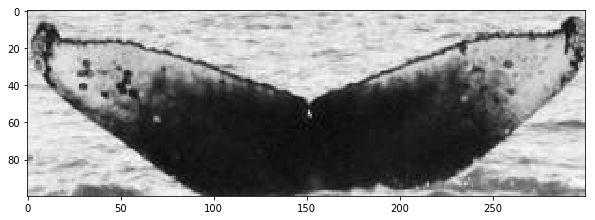

Picture 2: 


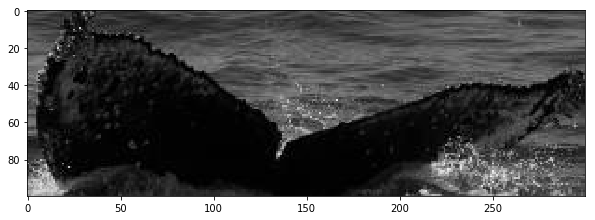

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


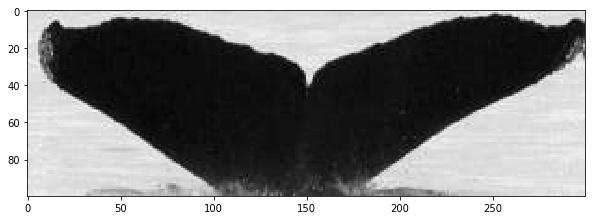

Picture 2: 


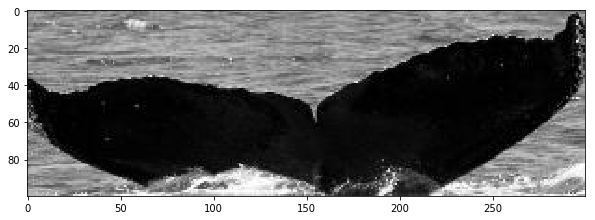

Dissimilarity: 22.680877685546875
Correct Label: 1
Picture 1: 


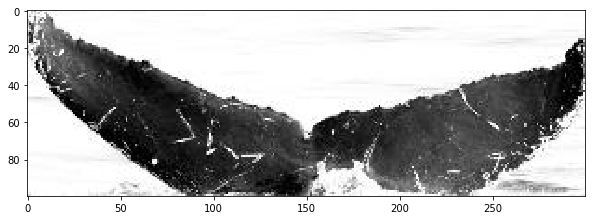

Picture 2: 


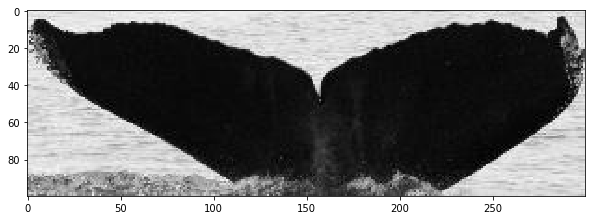

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


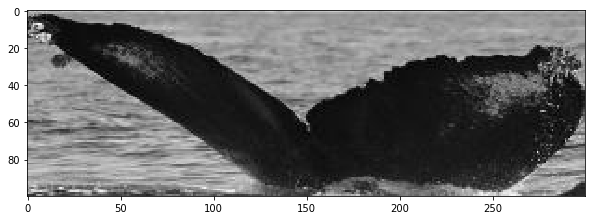

Picture 2: 


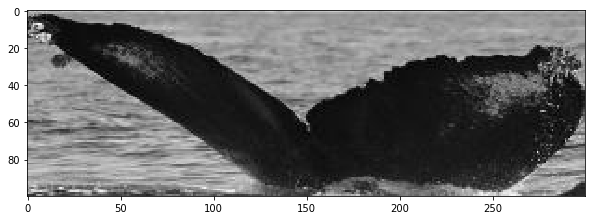

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


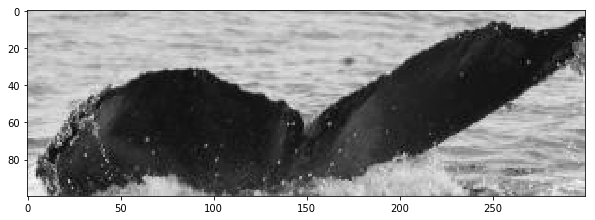

Picture 2: 


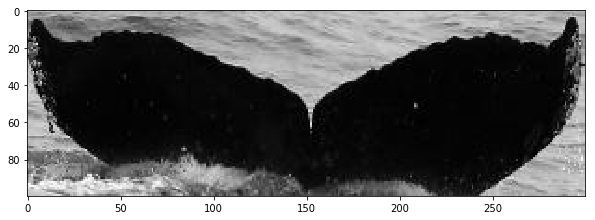

Dissimilarity: 199.8728790283203
Correct Label: 1
Picture 1: 


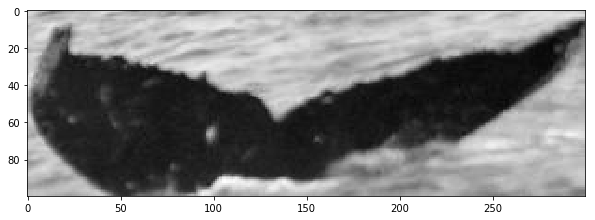

Picture 2: 


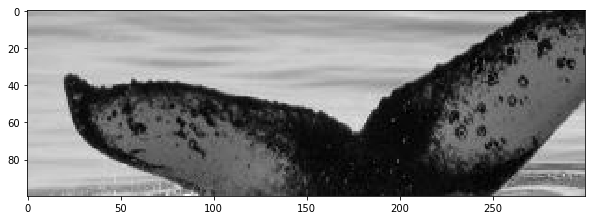

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


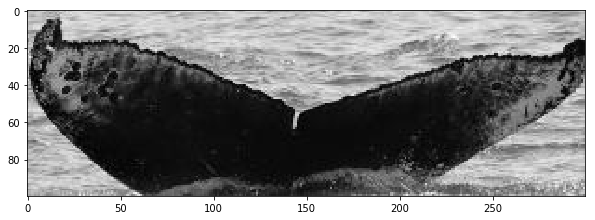

Picture 2: 


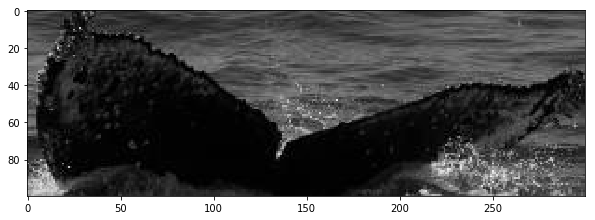

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


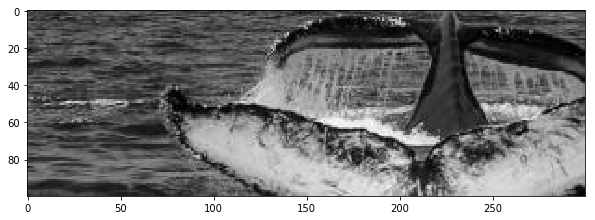

Picture 2: 


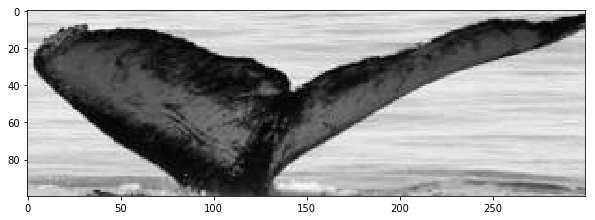

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


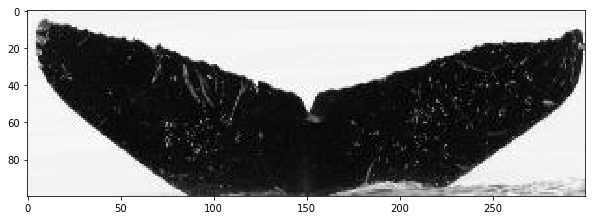

Picture 2: 


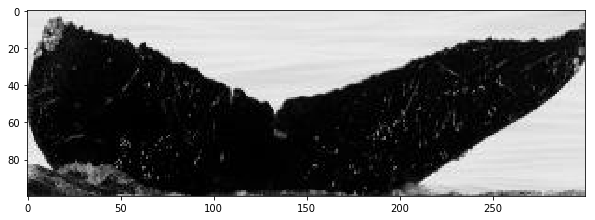

Dissimilarity: 1.3188046216964722
Correct Label: 1
Picture 1: 


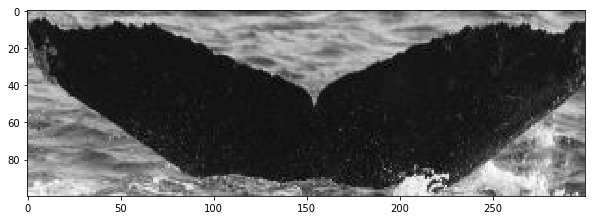

Picture 2: 


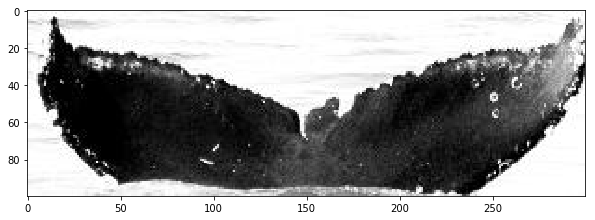

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


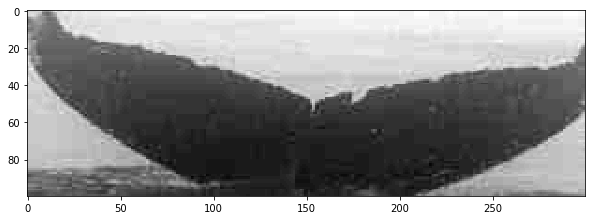

Picture 2: 


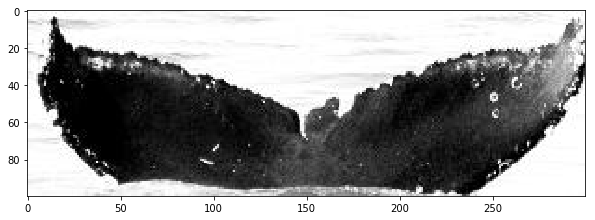

Dissimilarity: 56.31932067871094
Correct Label: 1
Picture 1: 


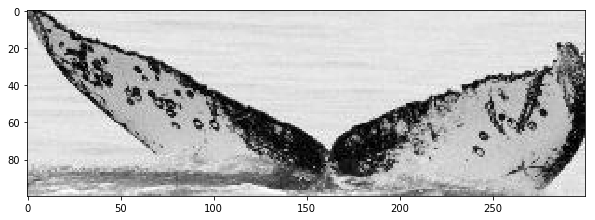

Picture 2: 


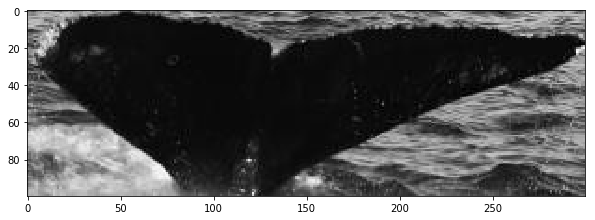

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


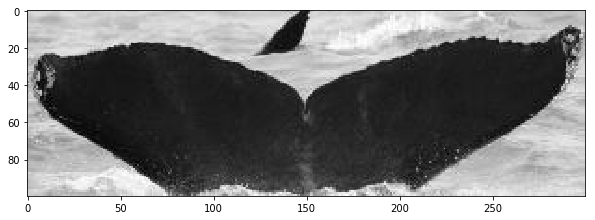

Picture 2: 


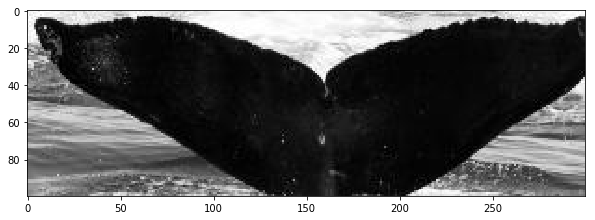

Dissimilarity: 103.68326568603516
Correct Label: 1
Picture 1: 


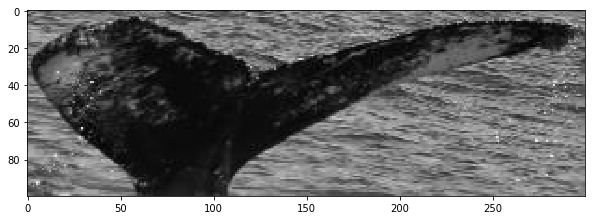

Picture 2: 


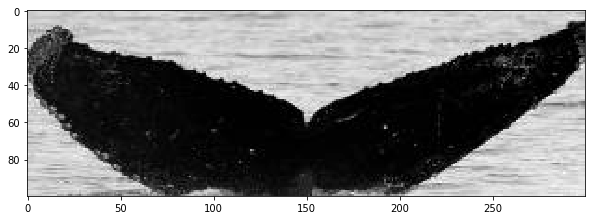

Dissimilarity: 7.5505876541137695
Correct Label: 1
Picture 1: 


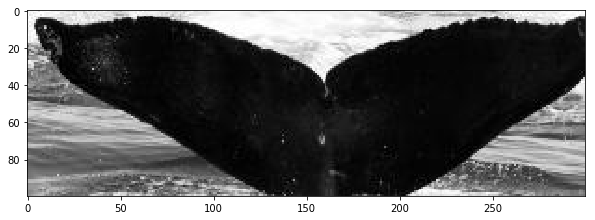

Picture 2: 


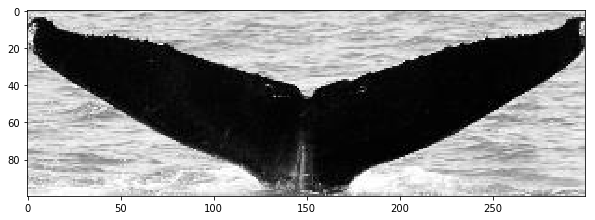

Dissimilarity: 182.20272827148438
Correct Label: 1
Picture 1: 


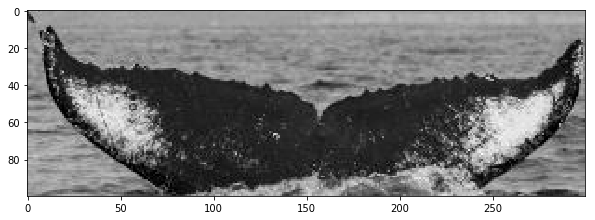

Picture 2: 


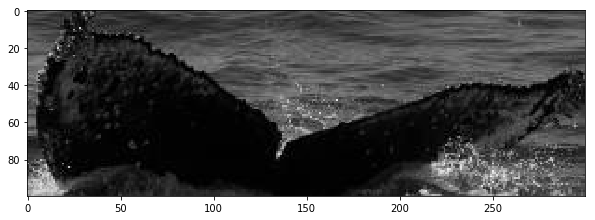

Dissimilarity: 103.68326568603516
Correct Label: 1
Picture 1: 


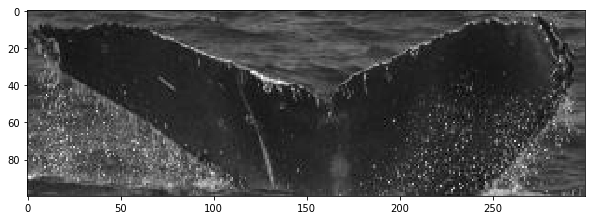

Picture 2: 


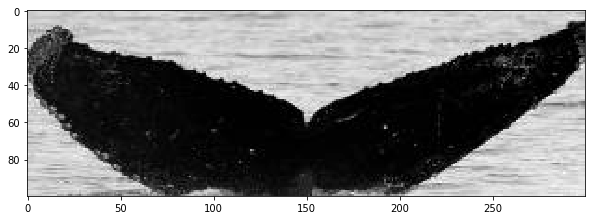

Dissimilarity: 0.10924425721168518
Correct Label: 1
Picture 1: 


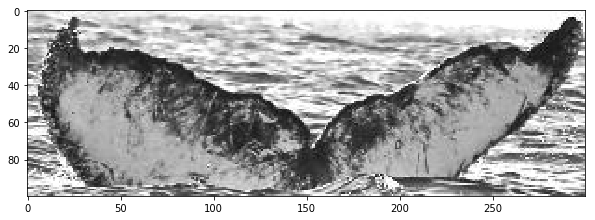

Picture 2: 


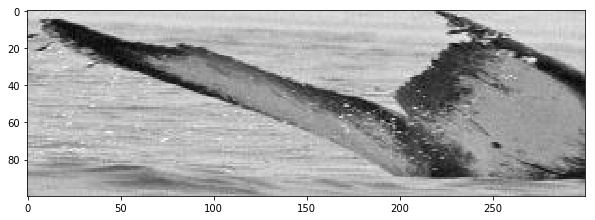

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


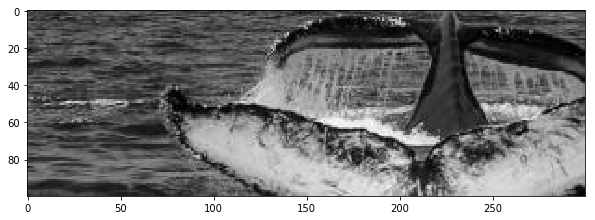

Picture 2: 


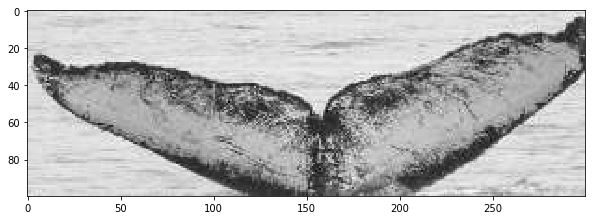

Dissimilarity: 22.308046340942383
Correct Label: 1
Picture 1: 


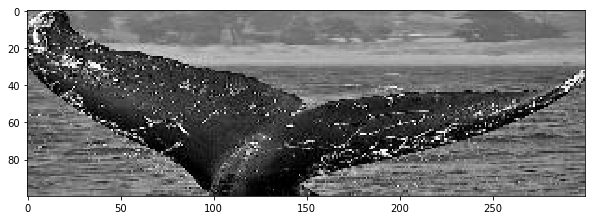

Picture 2: 


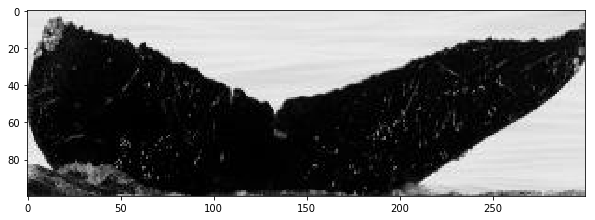

Dissimilarity: 446.98370361328125
Correct Label: 1
Picture 1: 


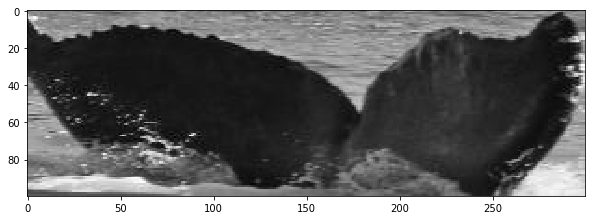

Picture 2: 


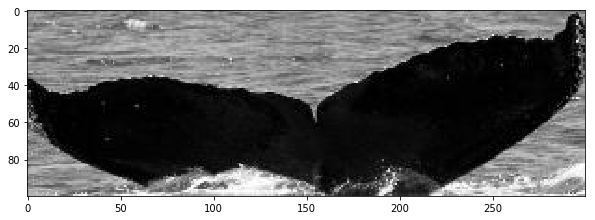

Dissimilarity: 31.150087356567383
Correct Label: 1
Picture 1: 


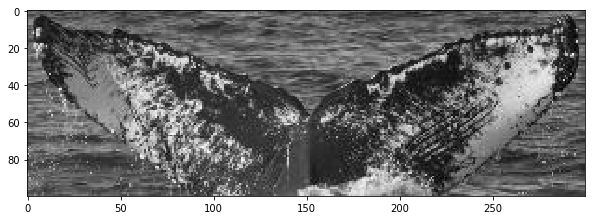

Picture 2: 


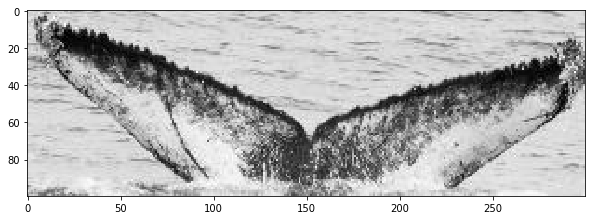

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


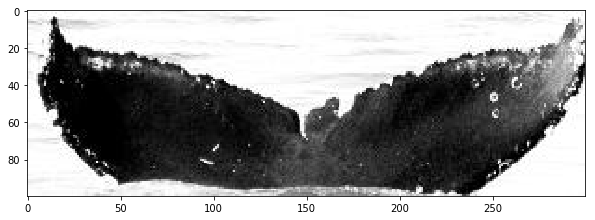

Picture 2: 


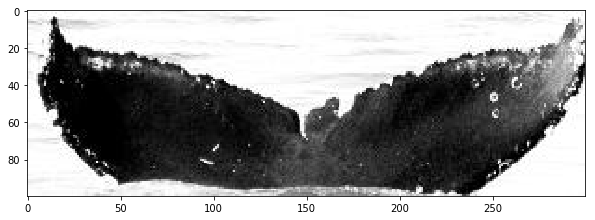

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


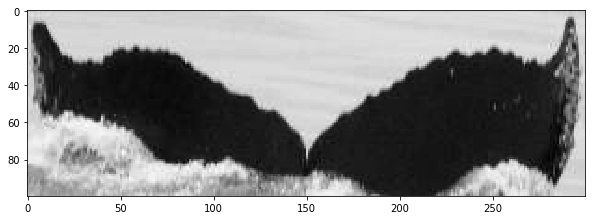

Picture 2: 


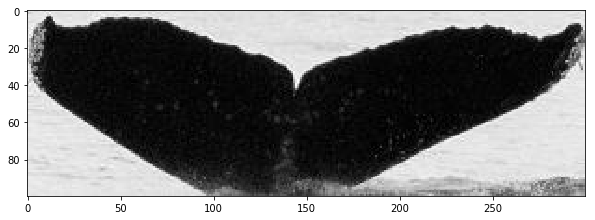

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


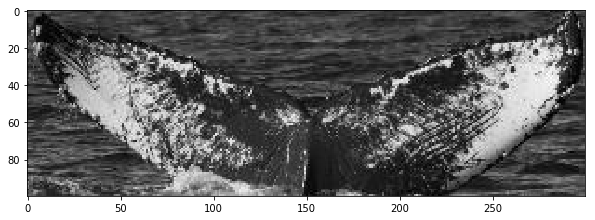

Picture 2: 


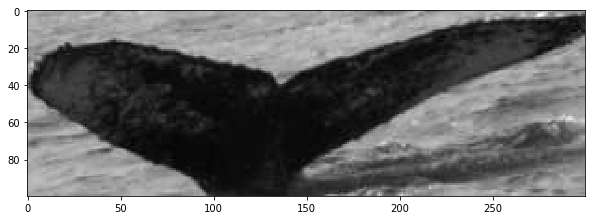

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


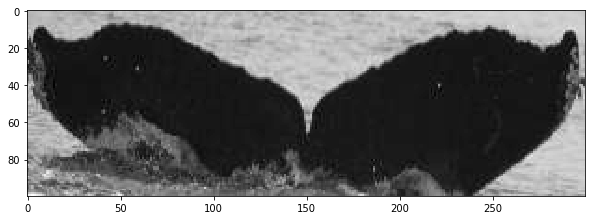

Picture 2: 


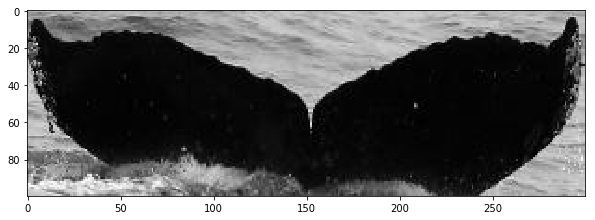

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


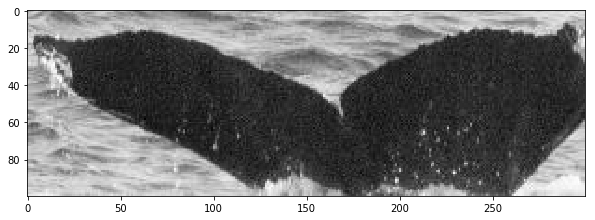

Picture 2: 


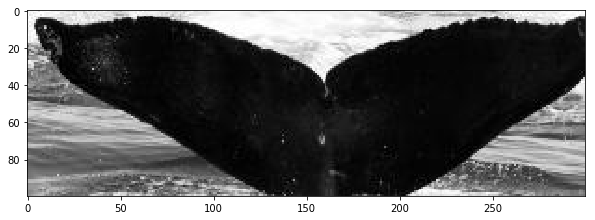

Dissimilarity: 170.8148651123047
Correct Label: 1
Picture 1: 


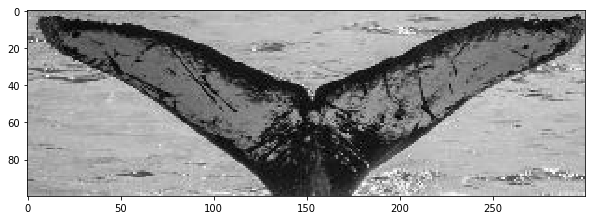

Picture 2: 


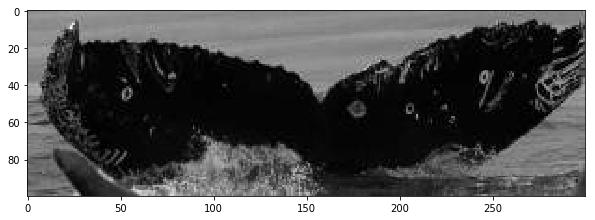

Dissimilarity: 785.9105224609375
Correct Label: 1
Picture 1: 


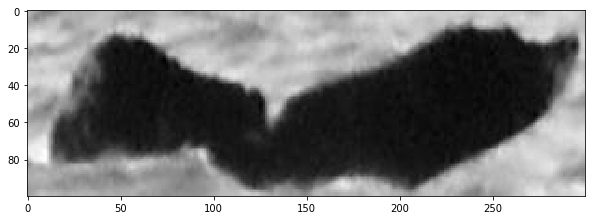

Picture 2: 


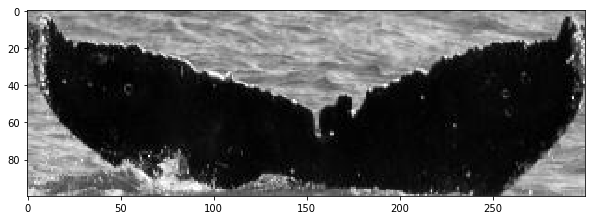

Dissimilarity: 22.680877685546875
Correct Label: 1
Picture 1: 


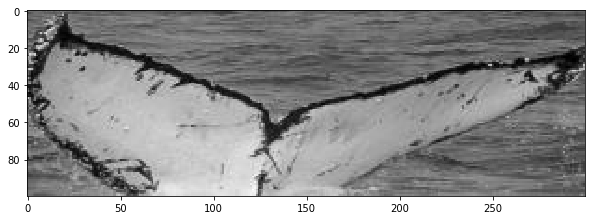

Picture 2: 


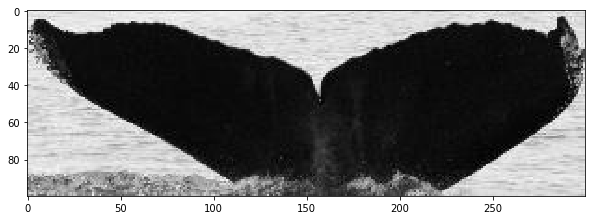

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


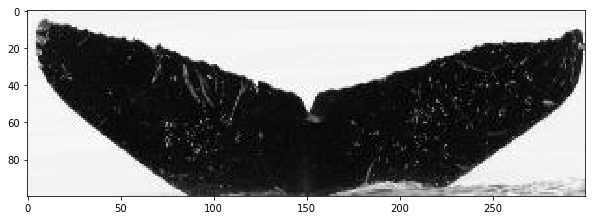

Picture 2: 


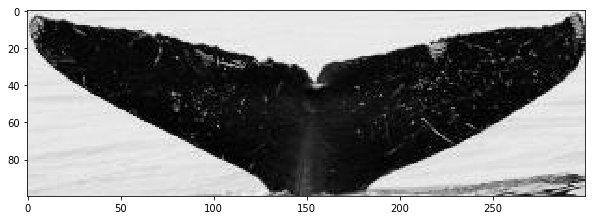

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


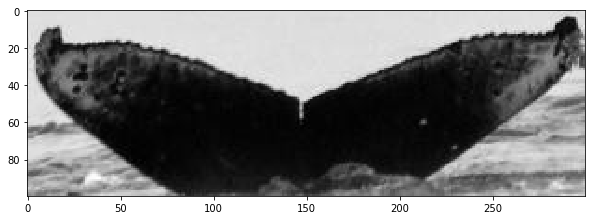

Picture 2: 


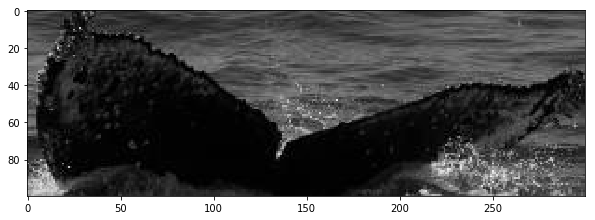

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


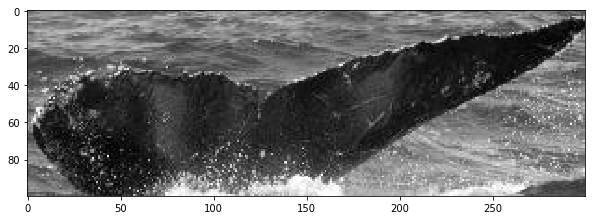

Picture 2: 


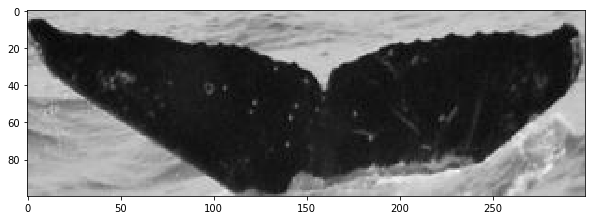

Dissimilarity: 199.8728790283203
Correct Label: 1
Picture 1: 


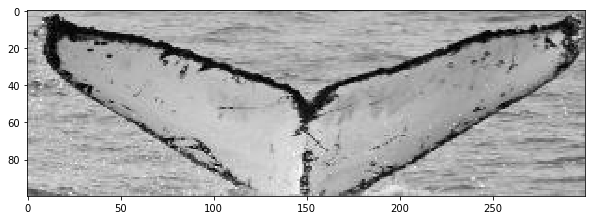

Picture 2: 


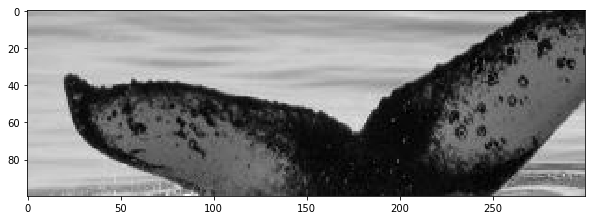

Dissimilarity: 22.308046340942383
Correct Label: 1
Picture 1: 


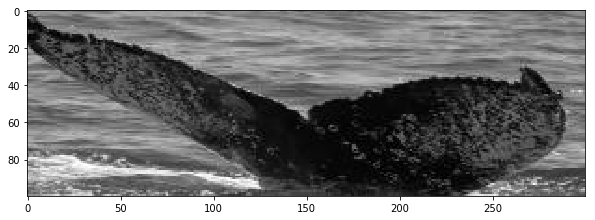

Picture 2: 


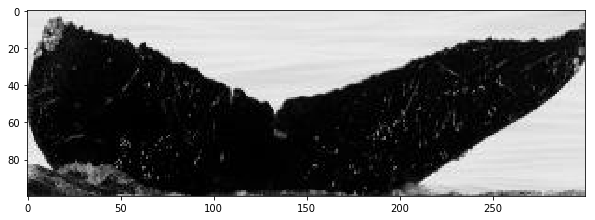

Dissimilarity: 22.308046340942383
Correct Label: 1
Picture 1: 


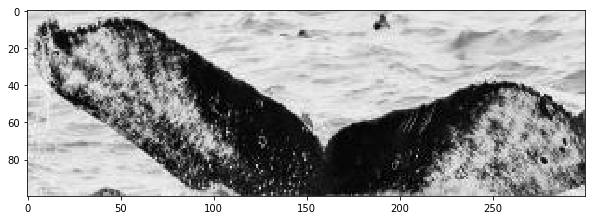

Picture 2: 


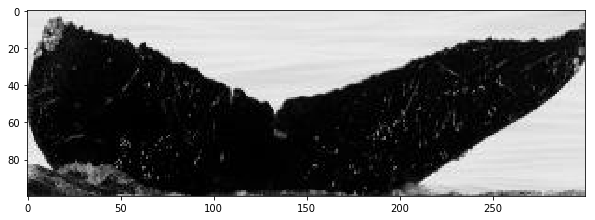

Dissimilarity: 122.75621795654297
Correct Label: 1
Picture 1: 


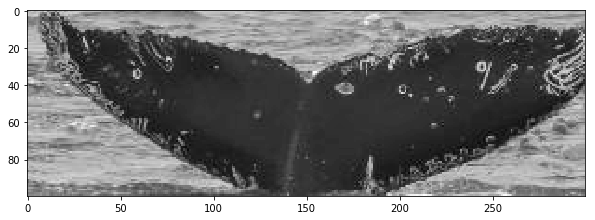

Picture 2: 


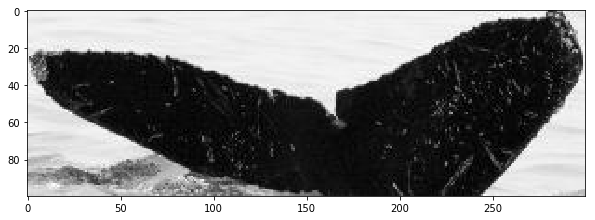

Dissimilarity: 149.4664306640625
Correct Label: 1
Picture 1: 


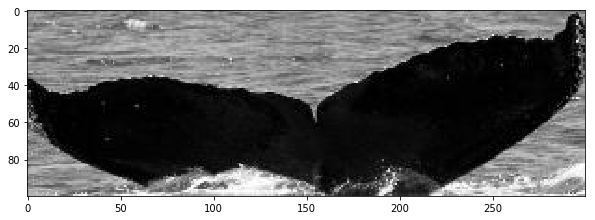

Picture 2: 


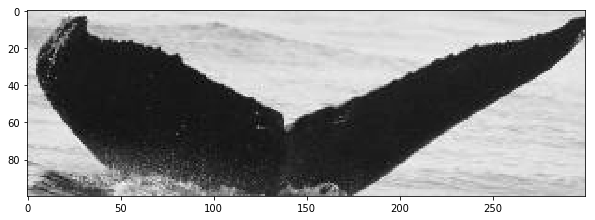

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


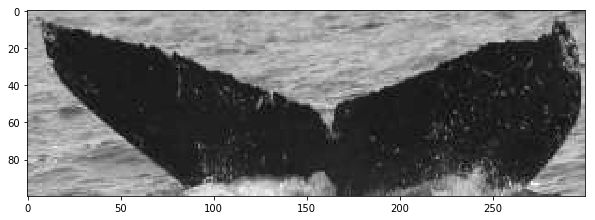

Picture 2: 


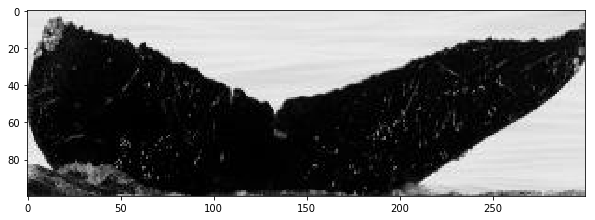

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


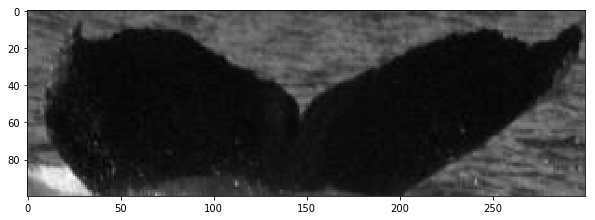

Picture 2: 


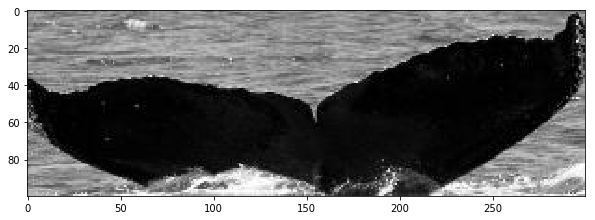

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


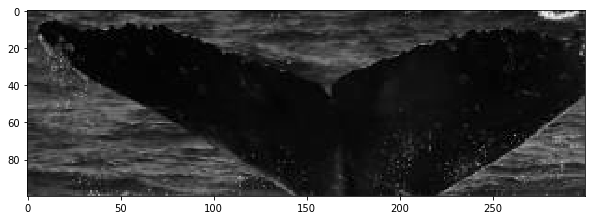

Picture 2: 


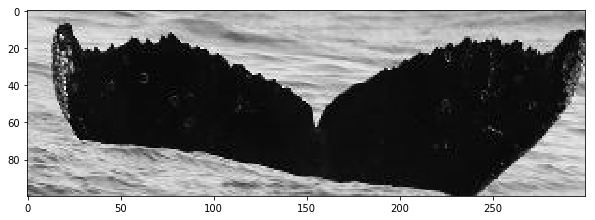

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


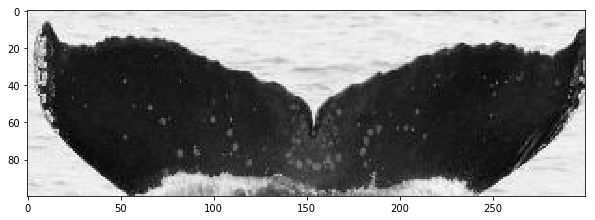

Picture 2: 


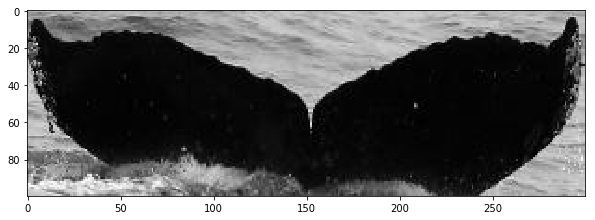

Dissimilarity: 156.29869079589844
Correct Label: 1
Picture 1: 


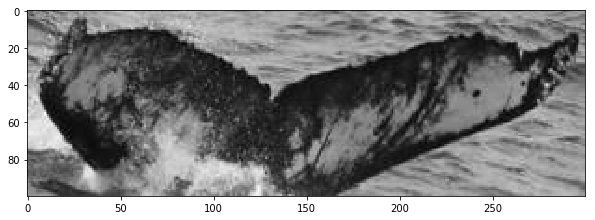

Picture 2: 


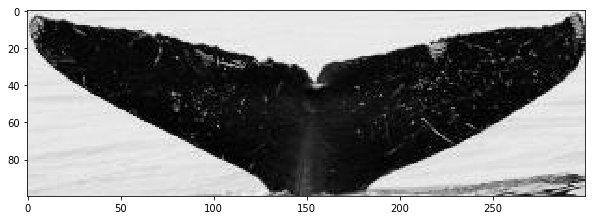

Dissimilarity: 149.4664306640625
Correct Label: 1
Picture 1: 


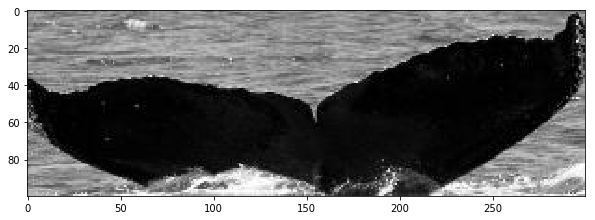

Picture 2: 


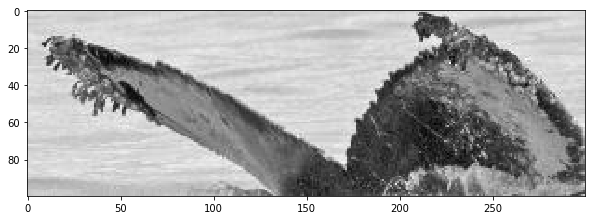

Dissimilarity: 199.8728790283203
Correct Label: 1
Picture 1: 


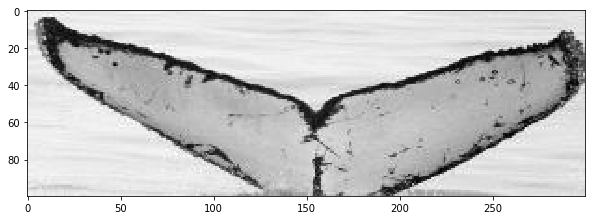

Picture 2: 


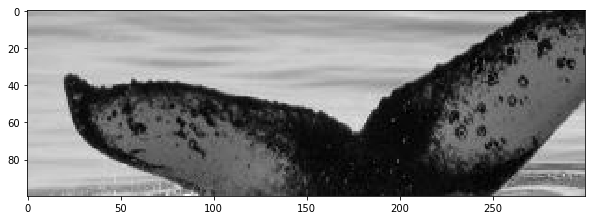

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


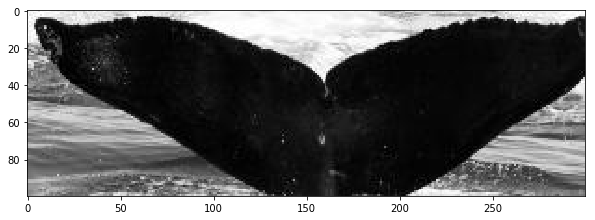

Picture 2: 


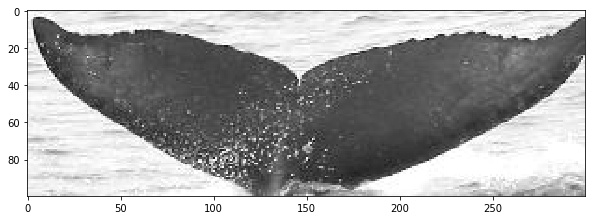

Dissimilarity: 156.29869079589844
Correct Label: 1
Picture 1: 


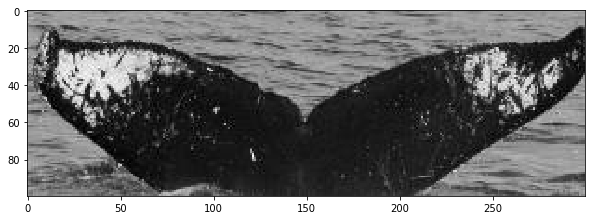

Picture 2: 


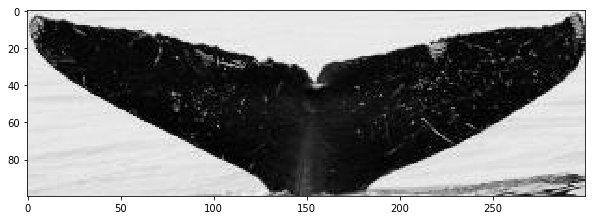

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


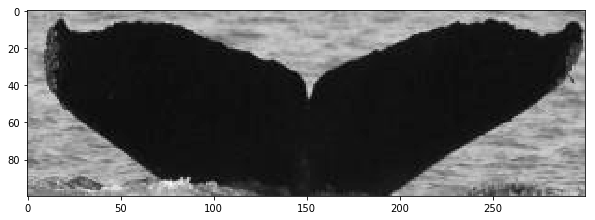

Picture 2: 


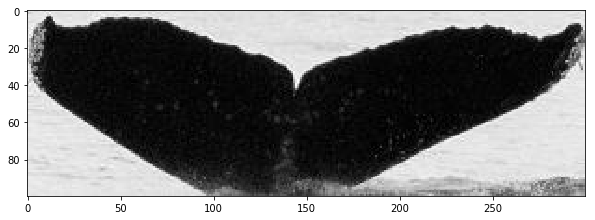

Dissimilarity: 23.0994930267334
Correct Label: 1
Picture 1: 


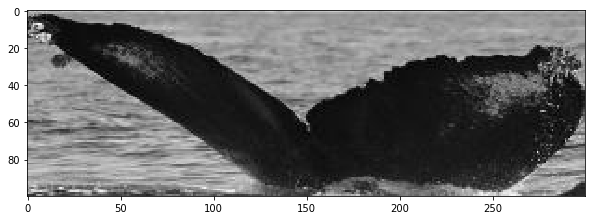

Picture 2: 


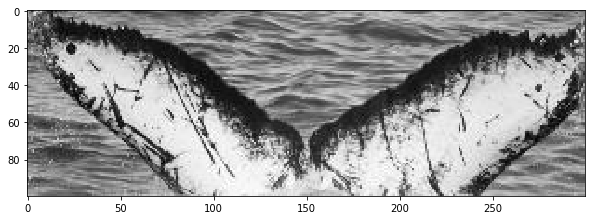

Dissimilarity: 31.150087356567383
Correct Label: 1
Picture 1: 


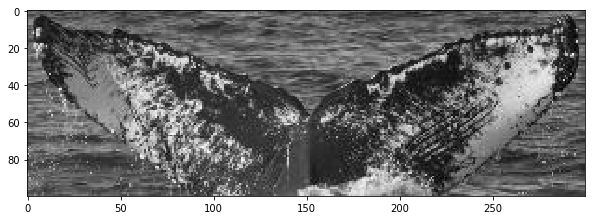

Picture 2: 


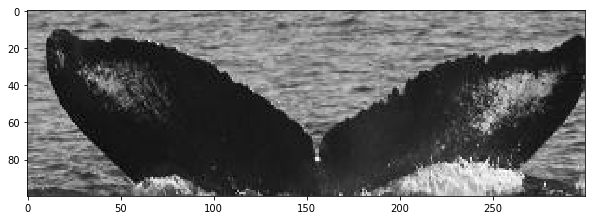

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


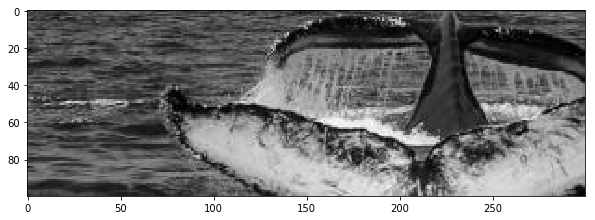

Picture 2: 


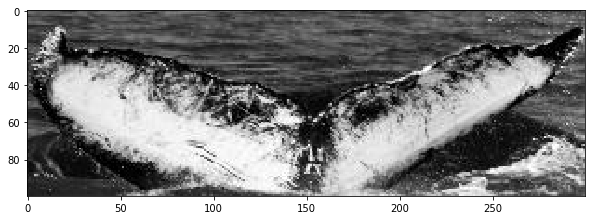

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


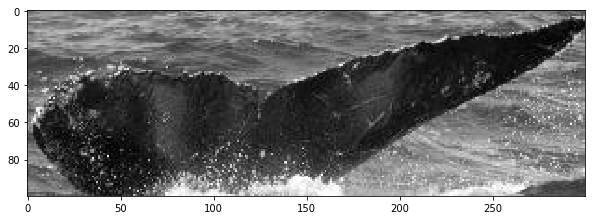

Picture 2: 


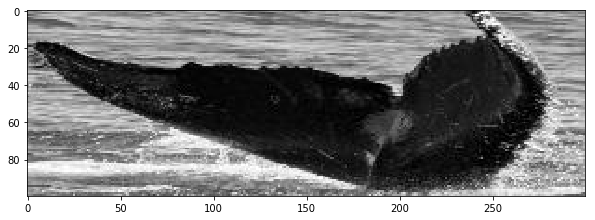

Dissimilarity: 0.0
Correct Label: 0
Picture 1: 


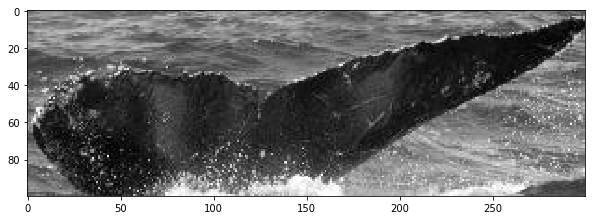

Picture 2: 


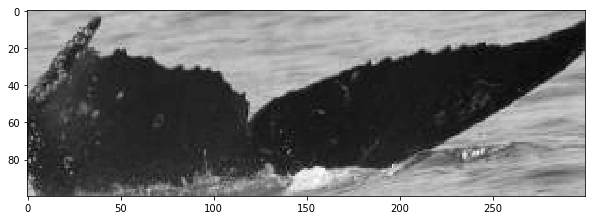

In [213]:
for i in range(len(outlier_indices)):
    if outlier_indices[i]:
        print(f"Dissimilarity: {losses[i]}")
        print(f"Correct Label: {train_labels[i]}")
        print("Picture 1: ")
        plt.figure(figsize=(10,5))
        plt.imshow(train_data[i,0,0], cmap="gray")
        plt.show()
        print("Picture 2: ")
        plt.figure(figsize=(10,5))
        plt.imshow(train_data[i,1,0], cmap="gray")
        plt.show()

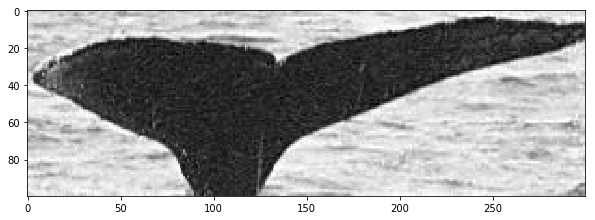

0


In [52]:
pic_a= train_data[1441][0]
plt.figure(figsize=(10,5))
plt.imshow(pic_a[0], cmap="gray")
plt.show()
print(train_labels[1441])

In [23]:
model1.show_example()

same whales? 1


FailedPreconditionError: Attempting to use uninitialized value first_model/conv2d_2/kernel
	 [[node first_model/conv2d_2/kernel/read (defined at <ipython-input-15-247b2b9db52d>:56)  = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](first_model/conv2d_2/kernel)]]
	 [[{{node first_model/Mean/_7}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_129_first_model/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'first_model/conv2d_2/kernel/read', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/beno/.local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/beno/.local/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/beno/.local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/beno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/beno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/beno/.local/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/beno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/beno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/beno/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-7ea9f43b3027>", line 8, in <module>
    model1.build(train_data.shape[4], train_data.shape[3])
  File "<ipython-input-15-247b2b9db52d>", line 56, in build
    padding='same', activation = tf.nn.relu)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/layers/convolutional.py", line 417, in conv2d
    return layer.apply(inputs)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 817, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 374, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 746, in __call__
    self.build(input_shapes)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/keras/layers/convolutional.py", line 165, in build
    dtype=self.dtype)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/layers/base.py", line 288, in add_weight
    getter=vs.get_variable)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py", line 609, in add_weight
    aggregation=aggregation)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/training/checkpointable/base.py", line 639, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1487, in get_variable
    aggregation=aggregation)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1237, in get_variable
    aggregation=aggregation)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 540, in get_variable
    aggregation=aggregation)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 492, in _true_getter
    aggregation=aggregation)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 922, in _get_single_variable
    aggregation=aggregation)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1329, in __init__
    constraint=constraint)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 1491, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 81, in identity
    return gen_array_ops.identity(input, name=name)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3454, in identity
    "Identity", input=input, name=name)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/beno/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value first_model/conv2d_2/kernel
	 [[node first_model/conv2d_2/kernel/read (defined at <ipython-input-15-247b2b9db52d>:56)  = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](first_model/conv2d_2/kernel)]]
	 [[{{node first_model/Mean/_7}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_129_first_model/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


model 1


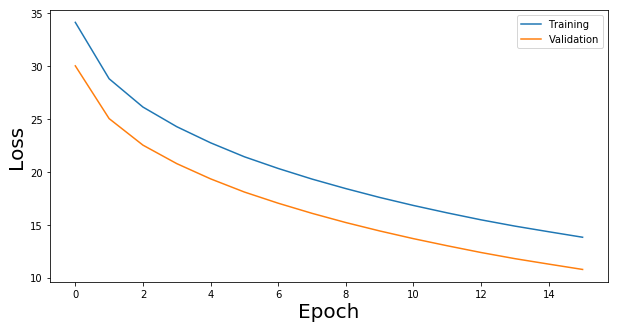

'\nprint("model 2")\nplt.figure(figsize=(10,5))\nplt.plot(model2.hist[\'train_loss\'][5::], label="Training")\nplt.plot(model2.hist[\'val_loss\'][5::], label="Validation")\n\nplt.xlabel("Epoch", fontsize=20)\nplt.ylabel("Loss", fontsize=20)\nplt.legend()\nplt.show()\n'

In [20]:

print("model 1")
plt.figure(figsize=(10,5))
plt.plot(model1.hist['train_loss'][5::], label="Training")
plt.plot(model1.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()
"""
print("model 2")
plt.figure(figsize=(10,5))
plt.plot(model2.hist['train_loss'][5::], label="Training")
plt.plot(model2.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()
"""

In [21]:
print(model1.hist["train_loss"])

[1.1721578e+06 2.1478146e+04 1.1560415e+03 1.3128229e+02 4.9628899e+01
 3.4117275e+01 2.8789366e+01 2.6119089e+01 2.4264885e+01 2.2743341e+01
 2.1423820e+01 2.0320402e+01 1.9318747e+01 1.8418867e+01 1.7585583e+01
 1.6825857e+01 1.6126211e+01 1.5469132e+01 1.4877202e+01 1.4345797e+01
 1.3826921e+01]


#### Now plot the training and validation accuracies over the epochs.

In [ ]:
print("model 1")
plt.figure(figsize=(10,5))

plt.plot(model1.hist['train_accuracy'])
plt.plot(model1.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()
"""
print("model 2")
plt.figure(figsize=(10,5))

plt.plot(model2.hist['train_accuracy'])
plt.plot(model2.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()
"""

In [ ]:
train_acc_1 = model1.hist['train_accuracy'][-1]
val_acc_1 = model1.hist['val_accuracy'][-1]
"""
train_acc_2 = model2.hist['train_accuracy'][-1]
val_acc_2 = model2.hist['val_accuracy'][-1]
"""
print(f"Training accuracy model 1: {train_acc_1:.3f}")
print(f"Validation accuracy model 1: {val_acc_1:.3f}")
print()
"""
print(f"Training accuracy model 2: {train_acc_2:.3f}")
print(f"Validation accuracy model 2: {val_acc_2:.3f}")
print()
"""

### Plot the losses and accuracies of the models in one plot to compare them.

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model1.hist['train_loss'][5::], label="Training model 1",
        color="darkgreen")
plt.plot(model1.hist['val_loss'][5::], label="Validation model 1",
        color="darkgreen", linestyle="--")
"""
plt.plot(model2.hist['train_loss'][5::], label="Training model 2",
        color="royalblue")
plt.plot(model2.hist['val_loss'][5::], label="Validation model 2",
        color="royalblue", linestyle="--")
"""
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

## Comparing the models
Now, compare the final training and validation losses achieved by the different models.

In [ ]:
plt.figure(figsize=(10,5))

plt.plot(model1.hist['train_accuracy'], label="Training model 1",
        color="darkgreen")
plt.plot(model1.hist['val_accuracy'], label="Validation model 1",
        color="darkgreen", linestyle="--")

plt.plot(model2.hist['train_accuracy'], label="Training model 2",
        color="royalblue")
plt.plot(model2.hist['val_accuracy'], label="Validation model 2",
        color="royalblue", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

In [ ]:
test_preds = NN_dropout_regularization.logits.eval({NN_dropout_regularization.X: test_data},
                                        session=NN_dropout_regularization.session).argmax(1)

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices({"feature": train_data, "label": train_labels})
val_data = tf.data.Dataset.from_tensor_slices({"feature": val_data, "label": val_labels})
train_data

In [ ]:
train_data.output_types

In [ ]:
#build batches
batch_size = 500
train_data.shuffle(30000)
batches = dataset.batch(batch_size)

In [ ]:


sess = tf.Session()
iterator = batches.make_one_shot_iterator()
next_element = iterator.get_next()
no_of_batches = int(np.ceil(labels.shape[0] / batch_size))
counter = 1
for i in tqdm(range(no_of_batches)):
    value = sess.run(next_element)
    print(value["feature"].shape)
    print(counter)
    counter+=1

sess.close()